In [ ]:
# Konfigurasi, Imports, dan Model Setup 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm

# --- KONFIGURASI PYTORCH ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = 70 
EPOCHS = 70
LEARNING_RATE = 1e-4 

# PATHS
DATA_DIR = '.' 
TRAIN_DIR = os.path.join(DATA_DIR, 'split/train') 
VAL_DIR = os.path.join(DATA_DIR, 'split/val')     
MODEL_NAME_FINAL = 'efficientnet_v5_pytorch_final.pth' # Format PyTorch .pth

print(f"Menggunakan Device: {DEVICE}")

# --- TRANSFORMASI DATA (AUGMENTASI AGRESIF) ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalisasi ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Menggunakan Device: cpu


In [ ]:
# PyTorch Dataset dan DataLoader

# 1. Muat Dataset (Menggunakan ImageFolder bawaan TorchVision)
try:
    image_datasets = {
        'train': ImageFolder(TRAIN_DIR, data_transforms['train']),
        'val': ImageFolder(VAL_DIR, data_transforms['val'])
    }
except Exception as e:
    print(f"[ERROR] Gagal memuat data dari direktori. Pastikan folder 'split/train' dan 'split/val' sudah ada. Error: {e}")
    sys.exit(1)

# 2. Buat DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x=='train'), num_workers=0)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
CLASS_NAMES = image_datasets['train'].classes
print(f"Jumlah Kelas: {len(CLASS_NAMES)}")
print(f"Sampel Training: {dataset_sizes['train']}, Sampel Validasi: {dataset_sizes['val']}")

Jumlah Kelas: 70
Sampel Training: 201, Sampel Validasi: 71


In [ ]:
# Definisi Model EfficientNetB0 (PyTorch)

def setup_efficientnet_b0(num_classes):
    # Muat EfficientNet B0, pre-trained di ImageNet
    # Menggunakan pretrained=True untuk kompatibilitas versi Torchvision
    model = models.efficientnet_b0(pretrained=True) 
    
    # Langsung Fine-Tuning (Semua layer akan diupdate)
    # Ganti classification head (classifier)
    num_ftrs = model.classifier[1].in_features
    
    # Custom Head: nn.Linear(input_features, num_classes)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.7, inplace=True), # TINGKATKAN KE 0.7
        nn.Linear(num_ftrs, num_classes)
)
    
    # Pindahkan model ke DEVICE (GPU atau CPU)
    model = model.to(DEVICE)
    
    # Tentukan Loss function dan Optimizer
    criterion = nn.CrossEntropyLoss()
    # Fine-Tuning pada semua parameter
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) 
    
    # Scheduler untuk mengurangi LR jika loss validasi tidak turun
    # KOREKSI: MENGHILANGKAN verbose=True
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    return model, criterion, optimizer, scheduler

model, criterion, optimizer, scheduler = setup_efficientnet_b0(NUM_CLASSES)
print("Model EfficientNetB0 berhasil disiapkan untuk Fine-Tuning.")

c:\Users\Asus\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Asus\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model EfficientNetB0 berhasil disiapkan untuk Fine-Tuning.


In [ ]:
# Training Loop (Fine-Tuning)

def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Setiap epoch memiliki fase training dan validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model ke mode training
            else:
                model.eval()   # Set model ke mode evaluasi

            running_loss = 0.0
            running_corrects = 0

            # Iterasi melalui data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} phase'):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Reset gradien
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimasi hanya di fase training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistik
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Jika di fase validasi, cek untuk penyimpanan model dan LR scheduler
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    # Simpan model terbaik
                    torch.save(model.state_dict(), MODEL_NAME_FINAL)
                    print(f"Checkpoint Saved: Loss Validasi turun menjadi {best_loss:.4f}. Model disimpan ke {MODEL_NAME_FINAL}")
                
                scheduler.step(epoch_loss) # Update Learning Rate
                
    print('\nTraining Complete.')
    return model, history

# Mulai Pelatihan
model_ft, history = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)


Epoch 1/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 4.3446 Acc: 0.0299


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 4.2478 Acc: 0.0000
Checkpoint Saved: Loss Validasi turun menjadi 4.2478. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 2/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 4.1958 Acc: 0.0249


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 4.2008 Acc: 0.0563
Checkpoint Saved: Loss Validasi turun menjadi 4.2008. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 3/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 4.1604 Acc: 0.0448


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 4.1639 Acc: 0.0704
Checkpoint Saved: Loss Validasi turun menjadi 4.1639. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 4/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 4.1151 Acc: 0.0348


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 4.1139 Acc: 0.0986
Checkpoint Saved: Loss Validasi turun menjadi 4.1139. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 5/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 4.0851 Acc: 0.0945


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 4.0654 Acc: 0.1268
Checkpoint Saved: Loss Validasi turun menjadi 4.0654. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 6/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 4.0412 Acc: 0.0846


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 4.0224 Acc: 0.1549
Checkpoint Saved: Loss Validasi turun menjadi 4.0224. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 7/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.9547 Acc: 0.1343


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.9756 Acc: 0.1831
Checkpoint Saved: Loss Validasi turun menjadi 3.9756. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 8/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.8451 Acc: 0.1443


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.9081 Acc: 0.2958
Checkpoint Saved: Loss Validasi turun menjadi 3.9081. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 9/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.8035 Acc: 0.1791


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.8576 Acc: 0.2817
Checkpoint Saved: Loss Validasi turun menjadi 3.8576. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 10/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.7122 Acc: 0.2637


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.7476 Acc: 0.3521
Checkpoint Saved: Loss Validasi turun menjadi 3.7476. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 11/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.6685 Acc: 0.1990


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.6713 Acc: 0.3662
Checkpoint Saved: Loss Validasi turun menjadi 3.6713. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 12/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.6449 Acc: 0.2886


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.5898 Acc: 0.4789
Checkpoint Saved: Loss Validasi turun menjadi 3.5898. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 13/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.5389 Acc: 0.2687


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.4827 Acc: 0.4789
Checkpoint Saved: Loss Validasi turun menjadi 3.4827. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 14/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.4142 Acc: 0.3781


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.3937 Acc: 0.4789
Checkpoint Saved: Loss Validasi turun menjadi 3.3937. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 15/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.3870 Acc: 0.3184


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.3250 Acc: 0.5070
Checkpoint Saved: Loss Validasi turun menjadi 3.3250. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 16/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.2266 Acc: 0.3930


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.2041 Acc: 0.5352
Checkpoint Saved: Loss Validasi turun menjadi 3.2041. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 17/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.1210 Acc: 0.4627


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.1290 Acc: 0.5211
Checkpoint Saved: Loss Validasi turun menjadi 3.1290. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 18/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 3.0929 Acc: 0.4428


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.0182 Acc: 0.5634
Checkpoint Saved: Loss Validasi turun menjadi 3.0182. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 19/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.9509 Acc: 0.4527


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.9178 Acc: 0.5352
Checkpoint Saved: Loss Validasi turun menjadi 2.9178. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 20/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.8888 Acc: 0.5224


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.8130 Acc: 0.5775
Checkpoint Saved: Loss Validasi turun menjadi 2.8130. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 21/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.8040 Acc: 0.5124


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.7103 Acc: 0.5775
Checkpoint Saved: Loss Validasi turun menjadi 2.7103. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 22/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.5975 Acc: 0.5970


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.6315 Acc: 0.5915
Checkpoint Saved: Loss Validasi turun menjadi 2.6315. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 23/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.6687 Acc: 0.5473


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.5499 Acc: 0.5775
Checkpoint Saved: Loss Validasi turun menjadi 2.5499. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 24/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.5726 Acc: 0.5622


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.4659 Acc: 0.5915
Checkpoint Saved: Loss Validasi turun menjadi 2.4659. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 25/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.3476 Acc: 0.6567


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.3832 Acc: 0.6056
Checkpoint Saved: Loss Validasi turun menjadi 2.3832. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 26/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.2208 Acc: 0.6965


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.2927 Acc: 0.6197
Checkpoint Saved: Loss Validasi turun menjadi 2.2927. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 27/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.2298 Acc: 0.6567


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.2317 Acc: 0.6056
Checkpoint Saved: Loss Validasi turun menjadi 2.2317. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 28/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.1944 Acc: 0.6468


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.1514 Acc: 0.6197
Checkpoint Saved: Loss Validasi turun menjadi 2.1514. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 29/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 2.0699 Acc: 0.6617


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.0868 Acc: 0.6197
Checkpoint Saved: Loss Validasi turun menjadi 2.0868. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 30/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.9664 Acc: 0.7015


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.0240 Acc: 0.6197
Checkpoint Saved: Loss Validasi turun menjadi 2.0240. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 31/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.7982 Acc: 0.7313


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.0057 Acc: 0.6197
Checkpoint Saved: Loss Validasi turun menjadi 2.0057. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 32/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.7739 Acc: 0.7114


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.9612 Acc: 0.6338
Checkpoint Saved: Loss Validasi turun menjadi 1.9612. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 33/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.6419 Acc: 0.7960


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.9073 Acc: 0.6338
Checkpoint Saved: Loss Validasi turun menjadi 1.9073. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 34/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.6231 Acc: 0.7711


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.8245 Acc: 0.6338
Checkpoint Saved: Loss Validasi turun menjadi 1.8245. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 35/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.5744 Acc: 0.7413


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7900 Acc: 0.6479
Checkpoint Saved: Loss Validasi turun menjadi 1.7900. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 36/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.5641 Acc: 0.8060


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7682 Acc: 0.6338
Checkpoint Saved: Loss Validasi turun menjadi 1.7682. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 37/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.4731 Acc: 0.7861


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7331 Acc: 0.6479
Checkpoint Saved: Loss Validasi turun menjadi 1.7331. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 38/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.3406 Acc: 0.8408


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6828 Acc: 0.6901
Checkpoint Saved: Loss Validasi turun menjadi 1.6828. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 39/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.3120 Acc: 0.8060


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6371 Acc: 0.6620
Checkpoint Saved: Loss Validasi turun menjadi 1.6371. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 40/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.2403 Acc: 0.8507


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6149 Acc: 0.6620
Checkpoint Saved: Loss Validasi turun menjadi 1.6149. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 41/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.2385 Acc: 0.8010


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.5715 Acc: 0.6901
Checkpoint Saved: Loss Validasi turun menjadi 1.5715. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 42/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.1473 Acc: 0.8507


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.5526 Acc: 0.6620
Checkpoint Saved: Loss Validasi turun menjadi 1.5526. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 43/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.9800 Acc: 0.9104


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.5385 Acc: 0.6761
Checkpoint Saved: Loss Validasi turun menjadi 1.5385. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 44/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.0306 Acc: 0.8657


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4944 Acc: 0.7042
Checkpoint Saved: Loss Validasi turun menjadi 1.4944. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 45/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.9617 Acc: 0.9005


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4674 Acc: 0.7042
Checkpoint Saved: Loss Validasi turun menjadi 1.4674. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 46/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 1.0654 Acc: 0.8259


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4416 Acc: 0.7042
Checkpoint Saved: Loss Validasi turun menjadi 1.4416. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 47/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.8958 Acc: 0.8905


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4102 Acc: 0.7042
Checkpoint Saved: Loss Validasi turun menjadi 1.4102. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 48/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.9238 Acc: 0.8657


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3980 Acc: 0.7183
Checkpoint Saved: Loss Validasi turun menjadi 1.3980. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 49/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.8310 Acc: 0.9055


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3794 Acc: 0.7042
Checkpoint Saved: Loss Validasi turun menjadi 1.3794. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 50/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.8627 Acc: 0.8806


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3730 Acc: 0.7042
Checkpoint Saved: Loss Validasi turun menjadi 1.3730. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 51/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.8468 Acc: 0.8955


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3272 Acc: 0.6901
Checkpoint Saved: Loss Validasi turun menjadi 1.3272. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 52/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.7956 Acc: 0.9154


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2969 Acc: 0.6901
Checkpoint Saved: Loss Validasi turun menjadi 1.2969. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 53/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.7880 Acc: 0.9104


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2706 Acc: 0.7042
Checkpoint Saved: Loss Validasi turun menjadi 1.2706. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 54/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6881 Acc: 0.9353


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2788 Acc: 0.7183

Epoch 55/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6249 Acc: 0.9353


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2712 Acc: 0.7183

Epoch 56/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.7162 Acc: 0.8955


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2638 Acc: 0.7324
Checkpoint Saved: Loss Validasi turun menjadi 1.2638. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 57/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6320 Acc: 0.9204


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2301 Acc: 0.7324
Checkpoint Saved: Loss Validasi turun menjadi 1.2301. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 58/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6720 Acc: 0.8905


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2321 Acc: 0.7042

Epoch 59/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5748 Acc: 0.9154


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2107 Acc: 0.7183
Checkpoint Saved: Loss Validasi turun menjadi 1.2107. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 60/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6065 Acc: 0.9154


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1914 Acc: 0.7183
Checkpoint Saved: Loss Validasi turun menjadi 1.1914. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 61/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5744 Acc: 0.9204


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1764 Acc: 0.7324
Checkpoint Saved: Loss Validasi turun menjadi 1.1764. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 62/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4932 Acc: 0.9602


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1717 Acc: 0.7183
Checkpoint Saved: Loss Validasi turun menjadi 1.1717. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 63/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.5136 Acc: 0.9502


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1758 Acc: 0.7465

Epoch 64/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4865 Acc: 0.9453


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1486 Acc: 0.7606
Checkpoint Saved: Loss Validasi turun menjadi 1.1486. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 65/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4177 Acc: 0.9652


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1310 Acc: 0.7465
Checkpoint Saved: Loss Validasi turun menjadi 1.1310. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 66/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4517 Acc: 0.9602


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1339 Acc: 0.7042

Epoch 67/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4579 Acc: 0.9453


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1425 Acc: 0.7042

Epoch 68/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.3745 Acc: 0.9652


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1023 Acc: 0.7324
Checkpoint Saved: Loss Validasi turun menjadi 1.1023. Model disimpan ke efficientnet_v5_pytorch_final.pth

Epoch 69/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.3816 Acc: 0.9701


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1210 Acc: 0.7183

Epoch 70/70
----------


train phase:   0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.4996 Acc: 0.9154


val phase:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1136 Acc: 0.7042

Training Complete.


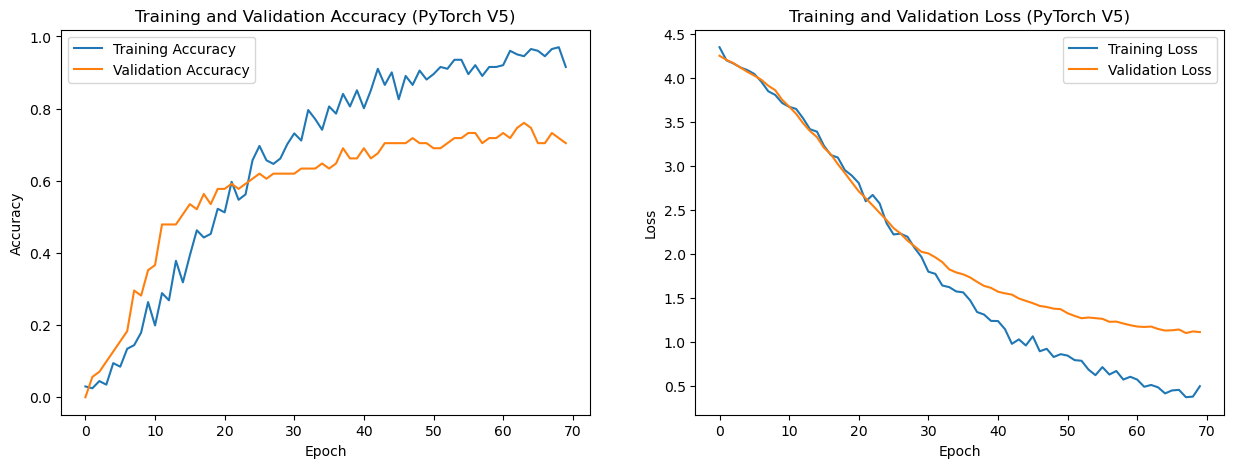

In [ ]:
# Visualisasi History

# Visualisasi History
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (PyTorch V5)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (PyTorch V5)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Memuat model terbaik dari efficientnet_v5_pytorch_final.pth...
Membuat prediksi pada data validasi...


Predicting:   0%|          | 0/5 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT (Metrik Wajib Tambahan) ---
              precision    recall  f1-score   support

   119140141     1.0000    1.0000    1.0000         1
   120140156     1.0000    1.0000    1.0000         1
   121140135     1.0000    1.0000    1.0000         1
   122140001     1.0000    1.0000    1.0000         1
   122140005     1.0000    1.0000    1.0000         1
   122140006     0.0000    0.0000    0.0000         1
   122140008     0.0000    0.0000    0.0000         1
   122140009     1.0000    1.0000    1.0000         1
   122140010     0.5000    1.0000    0.6667         1
   122140012     0.3333    1.0000    0.5000         1
   122140016     0.0000    0.0000    0.0000         1
   122140018     1.0000    1.0000    1.0000         1
   122140027     0.0000    0.0000    0.0000         1
   122140038     1.0000    1.0000    1.0000         1
   122140039     1.0000    1.0000    1.0000         1
   122140043     1.0000    1.0000    1.0000         1
   122140055     1.0000   

c:\Users\Asus\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\Asus\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
c:\Users\Asus\miniconda3\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\Asus\miniconda3\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes 

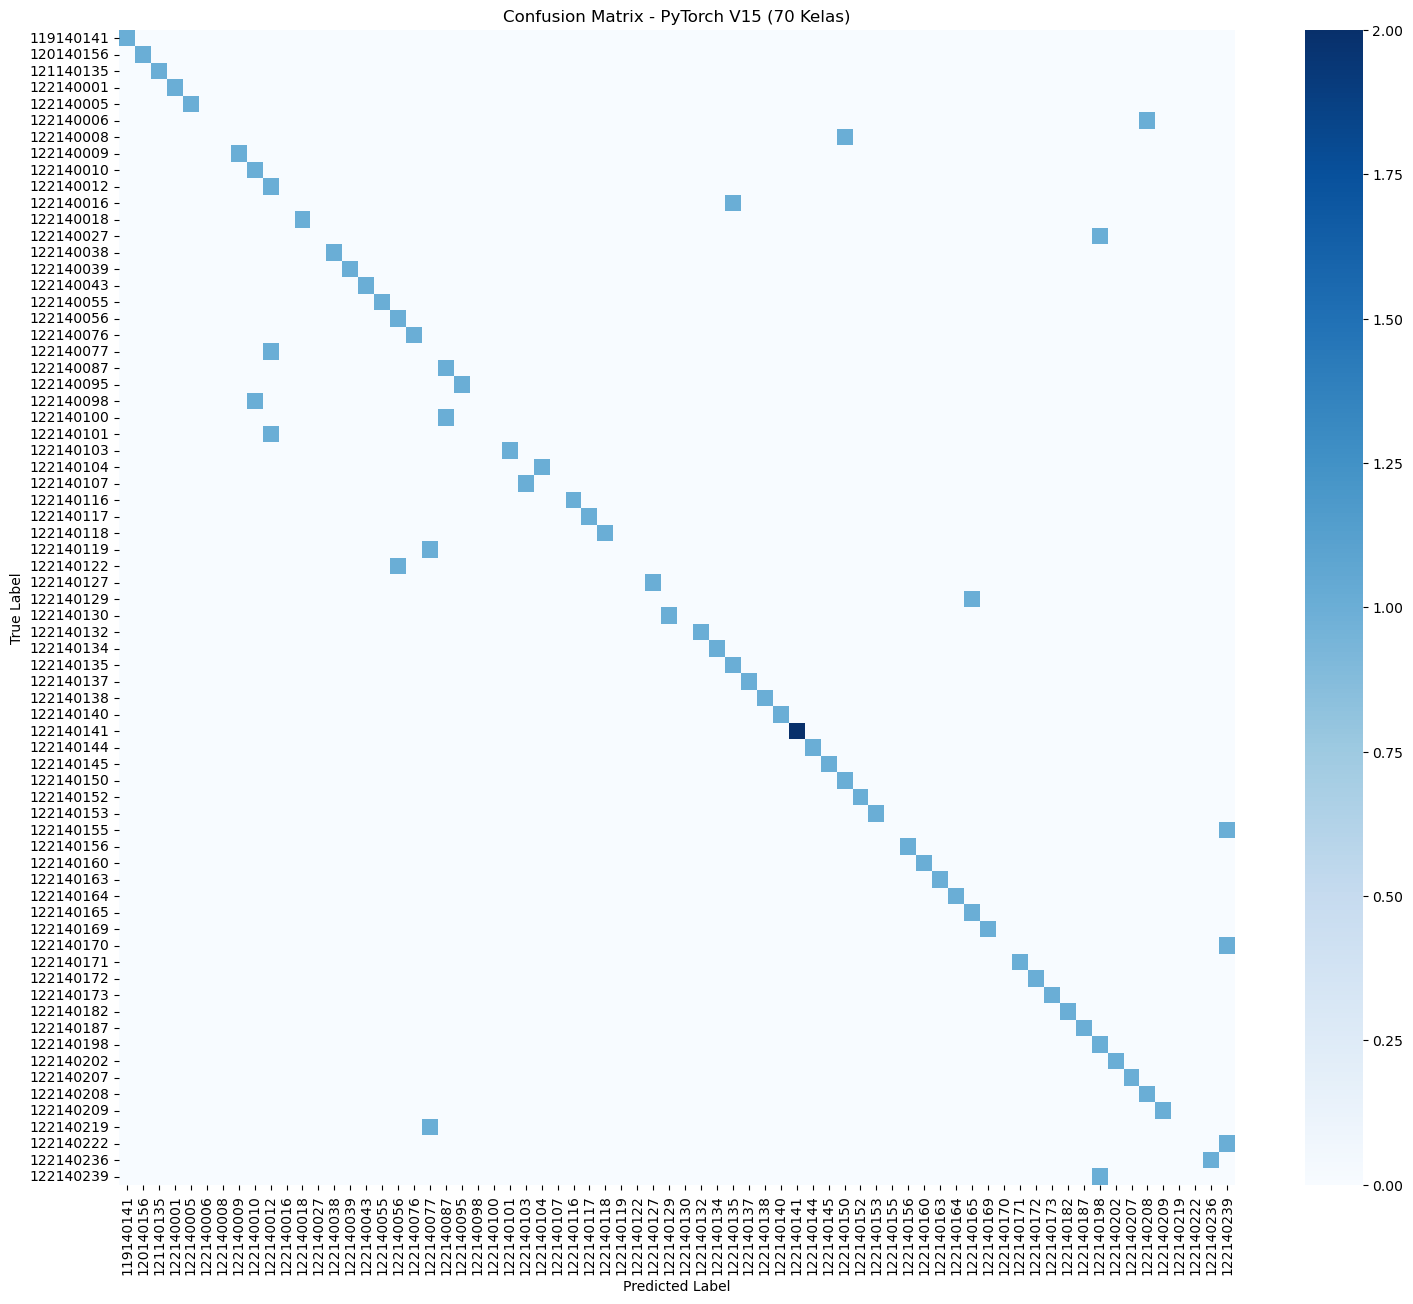

In [18]:
# Nama file laporan
REPORT_FILE_NAME = 'classification_report_v15.txt'

# Muat ulang model terbaik (dengan bobot terbaik) dari file .pth
print(f"Memuat model terbaik dari {MODEL_NAME_FINAL}...")
try:
    # model_ft dan CLASS_NAMES diasumsikan sudah didefinisikan di sel sebelumnya
    model_ft.load_state_dict(torch.load(MODEL_NAME_FINAL))
    model_ft.eval() # Set ke mode evaluasi
except Exception as e:
    print(f"[ERROR] Gagal memuat model terbaik: {e}")
    sys.exit(1)


all_preds = []
all_labels = []

print("Membuat prediksi pada data validasi...")

# Tidak perlu menghitung gradien selama evaluasi
with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['val'], desc='Predicting'):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Laporan Klasifikasi Penuh (Accuracy, Precision, Recall, F1-Score)
print("\n--- CLASSIFICATION REPORT (Metrik Wajib Tambahan) ---")

report = classification_report(
    all_labels, 
    all_preds, 
    target_names=CLASS_NAMES, 
    digits=4, 
    zero_division=0 
)

# 2. Cetak Laporan ke Output Notebook
print(report)

# 3. Tulis Laporan ke File .TXT (Revisi sesuai permintaan Anda)
with open(REPORT_FILE_NAME, 'w') as f:
    f.write(report)
print(f"\n✅ Laporan klasifikasi berhasil disimpan ke file: {REPORT_FILE_NAME}")


# 4. Hitung dan Visualisasi Confusion Matrix (Wajib)
cm = confusion_matrix(all_labels, all_preds)

print("\n--- CONFUSION MATRIX ---")

plt.figure(figsize=(18, 15))
sns.heatmap(
    cm, 
    annot=False, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=CLASS_NAMES, 
    yticklabels=CLASS_NAMES
)
plt.title(f'Confusion Matrix - PyTorch V15 ({len(CLASS_NAMES)} Kelas)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()